<a href="https://colab.research.google.com/github/mrezaim/Expanse/blob/main/EXPANSE_model_expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the implimentation of verifying the effectiveness of Model Expansion 
method from EXPANSE.

The details of idea is available in the paper of: Iman, Mohammadreza, Khaled Rasheed, and Hamid Reza Arabnia. “EXPANSE, A Continual Deep Learning System; Research Proposal”, International Conference on Computational Science and Computational Intelligence, IEEE CPS/IEEE Xplore (to appear in April 2022)


Some parts of the following codes are imported (with and without adjustments) from "https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/"


---



First we import all the necessary libraries:

---



In [ ]:
from google.colab import files
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import gdown
import cv2
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from numpy import mean
from numpy import std
# to make the results of different run similar:
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

Download and import Train and Test data from MNIST:

---



In [ ]:
# Loading the MNIST dataset
#from tensorflow.keras.datasets import mnist
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


Visualize 9 samples of data from MNIST Train dataset:

---



5 0 4 1 9 2 1 3 1 

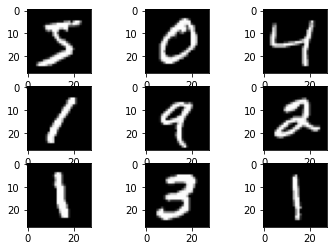

In [ ]:
j=0
for i in range(0,9):
  plt.subplot(330 + 1 + j)
  j += 1
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  print (trainy[i], end =" ")
plt.show()

Download the perfect samples pallet. It is a PNG file of 180 perfect samples 
(typed with different fonts).

---



In [ ]:
url = 'https://github.com/mrezaim/Expanse/raw/main/perfect_digits.png'
output = 'perfect_digits.png'
gdown.download(url, output, quiet=False)

Downloading...
From: https://github.com/mrezaim/Expanse/raw/main/perfect_digits.png
To: /content/perfect_digits.png
100%|██████████| 26.6k/26.6k [00:00<00:00, 3.80MB/s]


'perfect_digits.png'

Extracting 360 training samples from the perfect samples pallet and creatint train and test dataset by duplicate of samples. 

---



In [ ]:
img_path = 'perfect_digits.png'
img = cv2.imread(img_path, 0)
#train_per_x = np.empty_like(trainX)
train_per_x = np.zeros(shape = ( 360, 28, 28 ), dtype=np.uint8)
train_per_y = np.zeros(shape = ( 360), dtype=np.uint8)
i=0
for v in range(18):
  for h in range(10):
    train_per_x[i] = (img[4+(v*36):(v*36)+32, 4+(h*36):(h*36)+32])
    train_per_y[i] = h
    train_per_x[i+180] = (img[4+(v*36):(v*36)+32, 4+(h*36):(h*36)+32])
    train_per_y[i+180] = h
    i += 1

print('Perfect train dataset shape:', train_per_x.shape)
print('Perfect train label dataset shape:', train_per_y.shape)


Perfect train dataset shape: (360, 28, 28)
Perfect train label dataset shape: (360,)


Visualize 9 samples of data from perfect train dataset:

---



1 2 3 4 5 6 7 8 9 

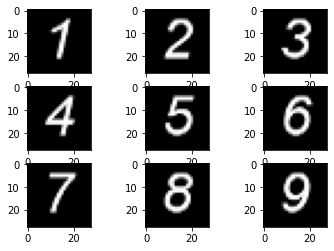

In [ ]:
j=0
for i in range(211,220):
  plt.subplot(330 + 1 + j)
  j += 1
  plt.imshow(train_per_x[i], cmap=plt.get_cmap('gray'))
  print (train_per_y[i], end =" ")
plt.show()

Dividing the MNIST train data and Perfect data to two batches of samples of 0-4 and 5-9:

In [ ]:
train_x_b1 = np.zeros(shape = ( 30596, 28, 28 ), dtype=np.uint8)
train_y_b1 = np.zeros(shape = ( 30596 ), dtype=np.uint8)
train_x_b2 = np.zeros(shape = ( 29404, 28, 28 ), dtype=np.uint8)
train_y_b2 = np.zeros(shape = ( 29404 ), dtype=np.uint8)
i=0
j=0
k=0
for i in (range(len(trainy))):
  if (trainy[i] == 0 or trainy[i] == 1 or trainy[i] == 2 or trainy[i] == 3 or trainy[i] == 4) :
    train_x_b1[j] = trainX[i]
    train_y_b1[j] = trainy[i]
    j += 1
  else:
    train_x_b2[k] = trainX[i]
    train_y_b2[k] = trainy[i]
    k += 1

print (len(train_y_b1))
print (len(train_y_b2))

30596
29404


In [ ]:
train_per_x_b1 = np.zeros(shape = ( 180, 28, 28 ), dtype=np.uint8)
train_per_y_b1 = np.zeros(shape = ( 180 ), dtype=np.uint8)
train_per_x_b2 = np.zeros(shape = ( 180, 28, 28 ), dtype=np.uint8)
train_per_y_b2 = np.zeros(shape = ( 180 ), dtype=np.uint8)
i=0
j=0
k=0
for i in (range(len(train_per_y))):
  if (train_per_y[i] == 0 or train_per_y[i] == 1 or train_per_y[i] == 2 or train_per_y[i] == 3 or train_per_y[i] == 4) :
    train_per_x_b1[j] = train_per_x[i]
    train_per_y_b1[j] = train_per_y[i]
    j += 1
  else:
    train_per_x_b2[k] = train_per_x[i]
    train_per_y_b2[k] = train_per_y[i]
    k += 1

print (len(train_per_y_b1))
print (len(train_per_y_b2))

180
180


Reshape datasets to prepare for the model

---



In [ ]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
train_x_b1 = train_x_b1.reshape((train_x_b1.shape[0], 28, 28, 1))
train_x_b2 = train_x_b2.reshape((train_x_b2.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

train_per_x_b1 = train_per_x_b1.reshape((train_per_x_b1.shape[0], 28, 28, 1))
train_per_x_b2 = train_per_x_b2.reshape((train_per_x_b2.shape[0], 28, 28, 1))
train_per_x = train_per_x.reshape((train_per_x.shape[0], 28, 28, 1))

Convert the label datasets to categorical since there are 10 possible target categories of digits:

---



In [ ]:
# one hot encode target values
trainy = tf.keras.utils.to_categorical(trainy)
train_y_b1 = tf.keras.utils.to_categorical(train_y_b1)
train_y_b2 = tf.keras.utils.to_categorical(train_y_b2)
train_per_y_b1 = tf.keras.utils.to_categorical(train_per_y_b1)
train_per_y_b2 = tf.keras.utils.to_categorical(train_per_y_b2)
testy = tf.keras.utils.to_categorical(testy)

train_per_y = tf.keras.utils.to_categorical(train_per_y)


Convert the datasets of images from 8-bit grayscale pixels values to float values and normalize the values to range of 0 and 1:

---



In [ ]:
# convert from integers to floats
trainX = trainX.astype('float32')
train_x_b1 = train_x_b1.astype('float32')
train_x_b2 = train_x_b2.astype('float32')
test_X = testX.astype('float32')
# normalize to range 0-1
trainX = trainX / 255.0
train_x_b1 = train_x_b1 / 255.0
train_x_b2 = train_x_b2 / 255.0
testX = testX / 255.0

# convert from integers to floats
train_per_x = train_per_x.astype('float32')
train_per_x_b1 = train_per_x_b1.astype('float32')
train_per_x_b2 = train_per_x_b2.astype('float32')
# normalize to range 0-1
train_per_x = train_per_x / 255.0
train_per_x_b1 = train_per_x_b1 / 255.0
train_per_x_b2 = train_per_x_b2 / 255.0


Defining the small and final model. Here we are using a dense relu based model with Adam optimizer and default learning rate of 0.001.

---



In [ ]:
model_small = Sequential()
model_small.add(Flatten())
model_small.add(Dense(150, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'))
model_small.add(Dense(80, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'))
model_small.add(Dense(5, activation='softmax'))
# compile model
opt = Adam(0.001)
model_small.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model_final = Sequential()
model_final.add(Flatten())
model_final.add(Dense(256, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'))
model_final.add(Dense(128, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'))
model_final.add(Dense(10, activation='softmax'))
# compile model
opt = Adam(0.0005)
model_final.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


The function to run the model on given dataset and parameters using k-fold cross-validation:

---



In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(model, dataX, dataY, n_folds, n_epochs, n_batch_size):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch_size, validation_data=(testX, testY))
		# evaluate model
		_, acc = model.evaluate(testX, testY)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories, model

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  for i in range(len(histories)):
      # plot loss
      plt.subplot(2, 2, 1)
      plt.title('Cross Entropy Loss')
      plt.plot(histories[i].history['loss'], color='blue', label='train')
      plt.plot(histories[i].history['val_loss'], color='orange', label='test')
      # plot accuracy
      plt.subplot(2, 2, 2)
      plt.title('Classification Accuracy')
      plt.plot(histories[i].history['accuracy'], color='blue', label='train')
      plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

Creating the base random intitialized model and save it to reuse for the baseline. We want to use same random weights for comparing different methods fairly:

---



In [ ]:
model_small.build((None, 28, 28, 1))
model_small.save("random_init_small")
model_final.build((None, 28, 28, 1))
model_final.save("random_init_final")

INFO:tensorflow:Assets written to: random_init_small/assets
INFO:tensorflow:Assets written to: random_init_final/assets


Creating a list to save each run performance 

---



In [ ]:
results = ([])

In [ ]:
model_small.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 150)               117750    
                                                                 
 dense_1 (Dense)             (None, 80)                12080     
                                                                 
 dense_2 (Dense)             (None, 5)                 405       
                                                                 
Total params: 130,235
Trainable params: 130,235
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
3/3 [==============================] - 2s 104ms/step - loss: 1.5447 - accuracy: 0.3148 - val_loss: 0.9341 - val_accuracy: 0.6111
Epoch 2/3
3/3 [==============================] - 0s 13ms/step - loss: 0.7380 - accuracy: 0.8025 - val_loss: 0.3904 - val_accuracy: 0.8889
Epoch 3/3
1/1 [==============================] - 0s 17ms/step - loss: 0.1320 - accuracy: 0.9444
> 94.444
Epoch 1/3
3/3 [==============================] - 0s 32ms/step - loss: 0.1441 - accuracy: 0.9568 - val_loss: 0.0943 - val_accuracy: 0.9444
Epoch 2/3
3/3 [==============================] - 0s 14ms/step - loss: 0.0500 - accuracy: 0.9691 - val_loss: 0.2061 - val_accuracy: 0.9444
Epoch 3/3
1/1 [==============================] - 0s 21ms/step - loss: 0.0365 - accuracy: 1.0000
> 100.000
Epoch 1/3
3/3 [==============================] - 0s 28ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0602 - val_accuracy: 1.0000
Epoch 2/3
3/3 [==============================] - 0s 14ms/step - loss: 0.0111 - accuracy: 1.0000 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


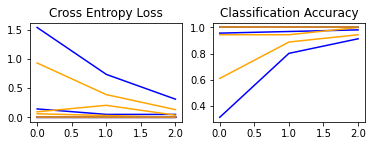

Accuracy: mean=99.444 std=1.667, n=10


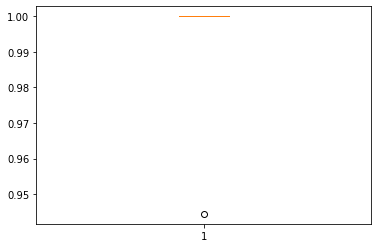

['Random initialized on per_b1 (0 to 4) with LR=0.01 & epoch=3', 100.0, 64.616]


In [ ]:
model = tf.keras.models.load_model("random_init_small")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.01)
scores, histories, model = evaluate_model(model, train_per_x_b1, train_per_y_b1,10,3,72)

model.save("trained_perfect_b1")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on per_b1 (0 to 4) with LR=0.01 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x_b1, train_per_y_b1, verbose=0)[1]*100,3),round(model.evaluate(train_x_b1, train_y_b1, verbose=0)[1]*100,3)])
print (results[len(results)-1])

In [ ]:
trainmixX_b1 = np. concatenate((train_x_b1, train_per_x_b1), axis=0)
trainmixy_b1 = np. concatenate((train_y_b1, train_per_y_b1), axis=0)
print(trainmixX_b1.shape)
print(trainmixy_b1.shape)

(30776, 28, 28, 1)
(30776, 5)


Epoch 1/3
385/385 [==============================] - 2s 4ms/step - loss: 0.2324 - accuracy: 0.9556 - val_loss: 0.0469 - val_accuracy: 0.9857
Epoch 2/3
385/385 [==============================] - 1s 4ms/step - loss: 0.0457 - accuracy: 0.9851 - val_loss: 0.0370 - val_accuracy: 0.9870
Epoch 3/3
97/97 [==============================] - 0s 2ms/step - loss: 0.0421 - accuracy: 0.9873
> 98.733
Epoch 1/3
385/385 [==============================] - 1s 3ms/step - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.0244 - val_accuracy: 0.9909
Epoch 2/3
385/385 [==============================] - 1s 4ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0425 - val_accuracy: 0.9873
Epoch 3/3
97/97 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9912
> 99.123
Epoch 1/3
385/385 [==============================] - 1s 4ms/step - loss: 0.0148 - accuracy: 0.9953 - val_loss: 0.0329 - val_accuracy: 0.9893
Epoch 2/3
385/385 [==============================] - 1s 3ms/step - loss: 0.0069 - a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


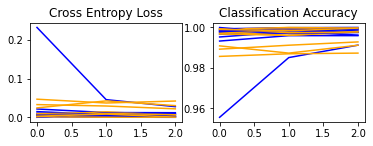

Accuracy: mean=99.633 std=0.411, n=10


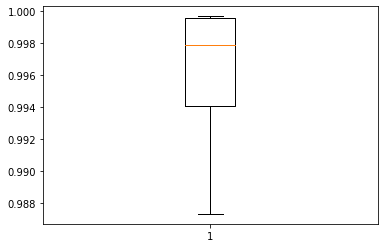

['trained_finetune_mix_b1 on mix data (0 to 4) with LR=0.002 & epoch=3', 100.0, 99.974]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_b1")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.002)
scores, histories, model = evaluate_model(model, trainmixX_b1, trainmixy_b1,10,3,72)

model.save("trained_finetune_mix_b1")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "trained_finetune_mix_b1 on mix data (0 to 4) with LR=0.002 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x_b1, train_per_y_b1, verbose=0)[1]*100,3),round(model.evaluate(train_x_b1, train_y_b1, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Updating random final model with weights from finetuned small size model.

In [ ]:
model_small = tf.keras.models.load_model("trained_finetune_mix_b1")
b = model_small.layers[1].get_weights()
a = model_final.layers[1].get_weights()
a[0][:784,:150]=b[0]
a[1][:150]=b[1]
model_final.layers[1].set_weights(a)

b = model_small.layers[2].get_weights()
a = model_final.layers[2].get_weights()
a[0][:150,:80]=b[0]
a[1][:80]=b[1]
model_final.layers[2].set_weights(a)

b = model_small.layers[3].get_weights()
a = model_final.layers[3].get_weights()
a[0][:80,:5]=b[0]
a[1][:5]=b[1]
model_final.layers[3].set_weights(a)

In [ ]:
model = model_final
model.layers[3].weights

[<tf.Variable 'dense_5/kernel:0' shape=(128, 10) dtype=float32, numpy=
 array([[ 0.10704491, -0.3751099 , -0.28861633, ..., -0.06922579,
         -0.19368218,  0.19751208],
        [ 0.18018271,  0.2200305 , -0.6636535 , ...,  0.06591536,
          0.15217833, -0.18056819],
        [-0.01373267, -0.06262822,  0.05092599, ...,  0.18087246,
         -0.18532431, -0.02270088],
        ...,
        [ 0.16366221,  0.00837985, -0.18337046, ...,  0.10956176,
         -0.04503307, -0.05266939],
        [ 0.10026087,  0.03059287, -0.06803022, ...,  0.12525181,
          0.14995717,  0.09157445],
        [ 0.17736737, -0.04620978,  0.1722687 , ...,  0.05302007,
         -0.17975482,  0.00868861]], dtype=float32)>,
 <tf.Variable 'dense_5/bias:0' shape=(10,) dtype=float32, numpy=
 array([-0.10687714, -0.41066825,  0.16213351, -0.04031408,  0.21503133,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       dtype=float32)>]

In [ ]:
model_final.save('final_model_loaded_weights')
desc = "final_model_loaded_weights without training"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

INFO:tensorflow:Assets written to: final_model_loaded_weights/assets
['final_model_loaded_weights without training', 50.556, 51.053, 51.07]


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trainmixX = np. concatenate((trainX, train_per_x), axis=0)
trainmixy = np. concatenate((trainy, train_per_y), axis=0)
print(trainmixX.shape)
print(trainmixy.shape)

(60360, 28, 28, 1)
(60360, 10)


Epoch 1/3
378/378 [==============================] - 3s 7ms/step - loss: 1.3248 - accuracy: 0.7460 - val_loss: 0.3562 - val_accuracy: 0.8897
Epoch 2/3
378/378 [==============================] - 2s 6ms/step - loss: 0.2753 - accuracy: 0.9164 - val_loss: 0.2195 - val_accuracy: 0.9314
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.1741 - accuracy: 0.9437
> 94.367
Epoch 1/3
378/378 [==============================] - 2s 6ms/step - loss: 0.1541 - accuracy: 0.9519 - val_loss: 0.1370 - val_accuracy: 0.9569
Epoch 2/3
378/378 [==============================] - 2s 6ms/step - loss: 0.1318 - accuracy: 0.9585 - val_loss: 0.1198 - val_accuracy: 0.9607
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.1097 - accuracy: 0.9654
> 96.537
Epoch 1/3
378/378 [==============================] - 2s 6ms/step - loss: 0.1048 - accuracy: 0.9670 - val_loss: 0.0956 - val_accuracy: 0.9717
Epoch 2/3
378/378 [==============================] - 2s 6ms/step - loss: 0.0945

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


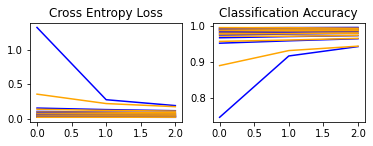

Accuracy: mean=97.919 std=1.453, n=10


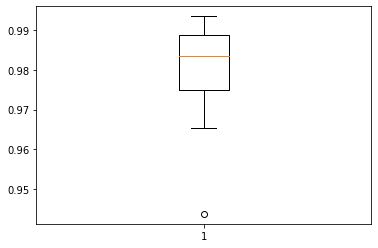

['final_model_loaded_weights on mix data with LR=0.0001 & epoch=3', 100.0, 99.642, 97.71]


In [ ]:
model = tf.keras.models.load_model("final_model_loaded_weights")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)



# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "final_model_loaded_weights on mix data with LR=0.0001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

In [ ]:
model.layers[3].weights

[<tf.Variable 'dense_5/kernel:0' shape=(128, 10) dtype=float32, numpy=
 array([[ 0.04702131, -0.42908487, -0.33677232, ..., -0.02172291,
         -0.25513512,  0.10466291],
        [ 0.1934608 ,  0.19222426, -0.67050964, ...,  0.04284181,
          0.1592738 , -0.2152883 ],
        [ 0.00294538, -0.10456863,  0.03800384, ...,  0.15334618,
         -0.1720101 ,  0.00577902],
        ...,
        [ 0.22788028,  0.02434869, -0.21619996, ...,  0.19411732,
         -0.07592392, -0.04455773],
        [ 0.08454202, -0.02565655, -0.10663281, ...,  0.14281687,
          0.18275191,  0.11828249],
        [ 0.18528861, -0.05789019,  0.20038101, ...,  0.05368187,
         -0.26640472,  0.06304621]], dtype=float32)>,
 <tf.Variable 'dense_5/bias:0' shape=(10,) dtype=float32, numpy=
 array([-0.12429737, -0.4669374 ,  0.11963599, -0.07524107,  0.2065192 ,
         0.01162014,  0.01194133,  0.00551102,  0.06145392,  0.01741724],
       dtype=float32)>]

Epoch 1/3
378/378 [==============================] - 3s 7ms/step - loss: 0.3049 - accuracy: 0.9220 - val_loss: 0.1159 - val_accuracy: 0.9632
Epoch 2/3
378/378 [==============================] - 2s 6ms/step - loss: 0.0814 - accuracy: 0.9742 - val_loss: 0.0894 - val_accuracy: 0.9717
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0748 - accuracy: 0.9776
> 97.763
Epoch 1/3
378/378 [==============================] - 3s 7ms/step - loss: 0.0414 - accuracy: 0.9876 - val_loss: 0.0396 - val_accuracy: 0.9856
Epoch 2/3
378/378 [==============================] - 2s 6ms/step - loss: 0.0302 - accuracy: 0.9904 - val_loss: 0.0362 - val_accuracy: 0.9881
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0363 - accuracy: 0.9877
> 98.774
Epoch 1/3
378/378 [==============================] - 2s 6ms/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 0.0135 - val_accuracy: 0.9970
Epoch 2/3
378/378 [==============================] - 2s 6ms/step - loss: 0.0120

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


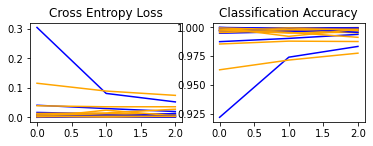

Accuracy: mean=99.400 std=0.649, n=10


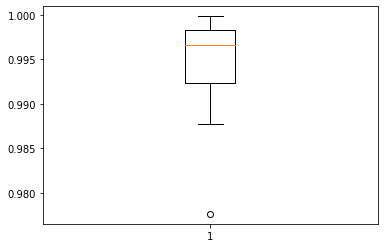

['final_model_loaded_weights on mix data with LR=0.001 & epoch=3', 100.0, 99.892, 98.04]


In [ ]:
model = tf.keras.models.load_model("final_model_loaded_weights")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)



# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "final_model_loaded_weights on mix data with LR=0.001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
378/378 [==============================] - 3s 7ms/step - loss: 0.2259 - accuracy: 0.9386 - val_loss: 0.1085 - val_accuracy: 0.9669
Epoch 2/3
378/378 [==============================] - 2s 6ms/step - loss: 0.0680 - accuracy: 0.9786 - val_loss: 0.0849 - val_accuracy: 0.9755
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0739 - accuracy: 0.9771
> 97.714
Epoch 1/3
378/378 [==============================] - 2s 6ms/step - loss: 0.0379 - accuracy: 0.9881 - val_loss: 0.0330 - val_accuracy: 0.9891
Epoch 2/3
378/378 [==============================] - 2s 6ms/step - loss: 0.0286 - accuracy: 0.9909 - val_loss: 0.0383 - val_accuracy: 0.9874
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9889
> 98.890
Epoch 1/3
378/378 [==============================] - 2s 6ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.0150 - val_accuracy: 0.9945
Epoch 2/3
378/378 [==============================] - 2s 6ms/step - loss: 0.0150

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


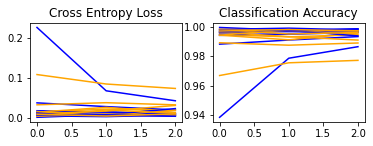

Accuracy: mean=99.291 std=0.589, n=10


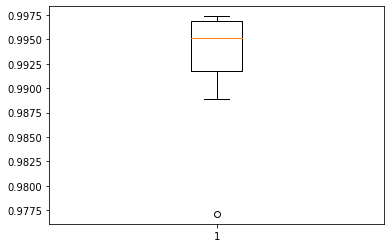

['final_model_loaded_weights on mix data with LR=0.002 & epoch=3', 100.0, 99.873, 98.09]


In [ ]:
model = tf.keras.models.load_model("final_model_loaded_weights")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.002)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)



# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "final_model_loaded_weights on mix data with LR=0.002 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Generating reults and download data:

---



In [ ]:
results

[['Random initialized on per_b1 (0 to 4) with LR=0.01 & epoch=3',
  100.0,
  64.616],
 ['trained_finetune_mix_b1 on mix data (0 to 4) with LR=0.002 & epoch=3',
  100.0,
  99.974],
 ['final_model_loaded_weights without training', 50.556, 51.053, 51.07],
 ['final_model_loaded_weights on mix data with LR=0.0001 & epoch=3',
  100.0,
  99.642,
  97.71],
 ['final_model_loaded_weights on mix data with LR=0.001 & epoch=3',
  100.0,
  99.892,
  98.04],
 ['final_model_loaded_weights on mix data with LR=0.002 & epoch=3',
  100.0,
  99.873,
  98.09]]

In [ ]:
import pandas
df=pandas.DataFrame(results,list(range(1, len(results)+1)),["Description","Train perfect", "Train MNIST", "Test MNIST"])
df

,Description,Train perfect,Train MNIST,Test MNIST
1,Random initialized on per_b1 (0 to 4) with LR=...,100.000,64.616,NaN
2,trained_finetune_mix_b1 on mix data (0 to 4) w...,100.000,99.974,NaN
3,final_model_loaded_weights without training,50.556,51.053,51.07
4,final_model_loaded_weights on mix data with LR...,100.000,99.642,97.71
5,final_model_loaded_weights on mix data with LR...,100.000,99.892,98.04
6,final_model_loaded_weights on mix data with LR...,100.000,99.873,98.09


In [ ]:
df.to_csv('results.csv', sep=',', encoding='utf-8')

In [ ]:
!zip -r /content/EXPANSE_Model_Expansion_colab.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.feature_flags_config.yaml (deflated 23%)
  adding: content/.config/.metricsUUID (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.03.23/ (stored 0%)
  adding: content/.config/logs/2022.03.23/14.20.51.700340.log (deflated 90%)
  adding: content/.config/logs/2022.03.23/14.21.47.434153.log (deflated 53%)
  adding: content/.config/logs/2022.03.23/14.22.10.115472.log (deflated 55%)
  adding: content/.config/logs/2022.03.23/14.22.11.024461.log (deflated 54%)
  adding: content/.config/logs/2022.03.23/14.21.37.874736.log (deflated 86%)
  adding: content/.config/logs/2022.03.23/14.21.15.158122.log (deflated 53%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)

In [ ]:
files.download('results.csv') 
files.download('EXPANSE_Model_Expansion_colab.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['hostname']=socket.gethostname()
        info['ip-address']=socket.gethostbyname(socket.gethostname())
        info['mac-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'architecture': 'x86_64',
 'hostname': '22d054318bde',
 'ip-address': '172.28.0.2',
 'mac-address': '02:42:ac:1c:00:02',
 'platform': 'Linux',
 'platform-release': '5.4.144+',
 'platform-version': '#1 SMP Tue Dec 7 09:58:10 PST 2021',
 'processor': 'x86_64',
 'ram': '13 GB'}